In [1]:
import json
import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import pandas as pd
import numpy as np
import nltk

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from gensim.corpora import Dictionary
from gensim.models import  LsiModel, LdaModel, TfidfModel

C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:06, 3044.41it/s]


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [5]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [6]:
df=pd.DataFrame.from_dict(responses)

In [7]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [9]:
# Удалим,где рейтинг не известен
df.dropna(subset=['rating_grade'], inplace = True)

In [10]:
df.shape

(88658, 10)

### 1. Посчитайте количество отзывов в разных городах и на разные банки

In [11]:
cities=df.groupby(['city']).count()['text'].sort_values( ascending=False).head(29)
banks=df.groupby(['bank_name']).count()['text'].sort_values( ascending=False).head(29)

Text(0.5, 0, 'Количество отзывов')

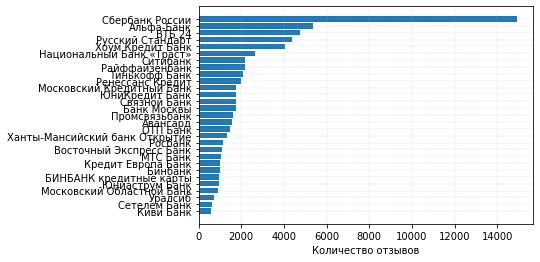

In [12]:
plt.barh(banks.index[::-1],banks.values[::-1])
plt.grid( linestyle='-.', linewidth=0.2)
plt.xlabel('Количество отзывов')

Text(0.5, 0, 'Количество отзывов')

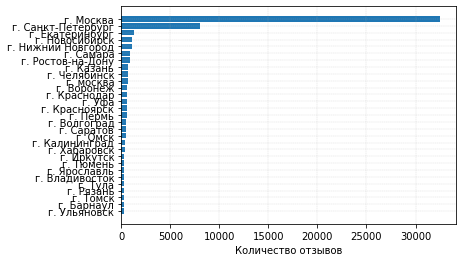

In [13]:
plt.barh(cities.index[::-1],cities.values[::-1])
plt.grid( linestyle='-.', linewidth=0.2)
plt.xlabel('Количество отзывов')

### 2. Постройте гистограмы длин слов в символах и в словах

In [14]:
#длина
len_chars = df.text.apply(len)
len_chars.describe()

count    88658.000000
mean      1718.655711
std       1387.903005
min         31.000000
25%        852.000000
50%       1345.000000
75%       2131.000000
max      32082.000000
Name: text, dtype: float64

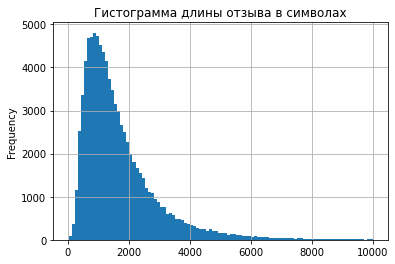

In [15]:
len_chars[len_chars<10000].plot(kind='hist',bins=100, title='Гистограмма длины отзыва в символах')

plt.grid(True)


In [16]:
len_tokens = df.text.str.split().apply(len)
len_tokens.describe()

count    88658.00000
mean       262.54814
std        213.16522
min          5.00000
25%        129.00000
50%        205.00000
75%        326.00000
max       5000.00000
Name: text, dtype: float64

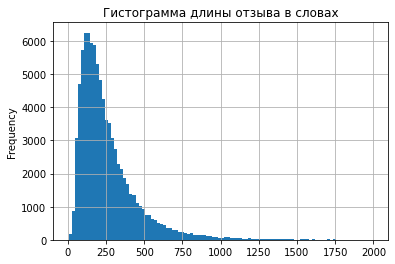

In [17]:
len_tokens[len_tokens<2000].plot(kind='hist',bins=100, title='Гистограмма длины отзыва в словах')
plt.grid(True)

### Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм

#### Cлова

In [18]:
import re
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [19]:
df['text_tokinized'] =  df.text.str.lower().apply(words_only)

In [20]:
from collections import Counter
from tqdm import tqdm_notebook as tqdm
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['text_tokinized'].split()
    #print(tokens)
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
for i in cnt.most_common(10):
    print(i)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/88658 [00:00<?, ?it/s]

('в', 859205)
('и', 683760)
('не', 541870)
('на', 453390)
('что', 417356)
('я', 368386)
('с', 288214)
('по', 232882)
('мне', 209093)
('банка', 171118)


#### Cлова без стоп-слов

In [21]:
from nltk.corpus import stopwords
 #print(stopwords.words('russian'))
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return 

In [22]:
df['text_tokinized_without_stop_worlds'] =  df.text_tokinized.str.lower().apply(remove_stopwords)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,text_tokinized,text_tokinized_without_stop_worlds
14,г. Москва,False,В Шоке,0,лицензия № 2673,yura1189,Тинькофф Банк,2015-06-05 13:52:40,"Также как и многие давний клиент банка, был до...",2.0,также как и многие давний клиент банка был дов...,многие давний клиент банка доволен высшей степ...
19,г. Москва,False,Некомпетентность сотрудников банка,2,лицензия № 1481,agelun,Сбербанк России,2015-06-05 15:00:54,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0,открыт вклад и счет в плюс к этому есть зарпла...,открыт вклад счет плюс этому зарплатная карта ...
33,г. Ростов-на-Дону,False,Навязывание страховки,1,лицензия № 1481,Joker888,Сбербанк России,2015-06-05 21:35:40,Доброго времени! Вчера мне поступило смс-уведо...,1.0,доброго времени вчера мне поступило смс уведом...,доброго времени вчера поступило смс уведомлени...
76,г. Санкт-Петербург,False,Нарушение договора банковского вклада,0,лицензия № 3006,qwarta45,АктивКапитал Банк,2015-06-06 23:42:39,"05.06.2015г. около 15 часов, пришел в указанны...",1.0,г около часов пришел в указанный офис с намере...,г около часов пришел указанный офис намерением...
85,г. Москва,False,"Невозможно оплатить отчисления на капремонт ""Т...",4,лицензия № 1481,721,Сбербанк России,2015-06-04 13:27:04,Для оплаты коммунальных платежей пользуюсь пла...,1.0,для оплаты коммунальных платежей пользуюсь пла...,оплаты коммунальных платежей пользуюсь пластик...


In [23]:
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
tokens_all=[]
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['text_tokinized_without_stop_worlds'].split()
    tokens_all+=tokens
    #print(tokens)
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
for i in cnt.most_common(10):
    print(i)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/88658 [00:00<?, ?it/s]

('банка', 171118)
('банк', 130753)
('деньги', 83171)
('карту', 69033)
('карты', 63121)
('отделение', 48431)
('день', 48092)
('кредит', 47746)
('банке', 46245)
('заявление', 45279)


#### Леммы

In [24]:
from pymorphy2 import MorphAnalyzer
# from pymystem3 import Mystem
# m = Mystem()             #оооочень долго..
pm2 = MorphAnalyzer()

def lemmatize(text, typelem=pm2):
    try:
        lemmas = [pm2.parse(word)[0].normal_form for word in text.split()]
        return ' '.join(lemmas)
    except:
        return " "

In [25]:
mystoplemmas = stopwords.words('russian') + ['который','прошлый','сей', 'свой', 'наш', 'мочь']
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

In [26]:
%%time
df['lemma'] = df['text_tokinized_without_stop_worlds'].apply(lemmatize)

Wall time: 29min 55s


In [27]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,text_tokinized,text_tokinized_without_stop_worlds,lemma
14,г. Москва,False,В Шоке,0,лицензия № 2673,yura1189,Тинькофф Банк,2015-06-05 13:52:40,"Также как и многие давний клиент банка, был до...",2.0,также как и многие давний клиент банка был дов...,многие давний клиент банка доволен высшей степ...,многие давний клиент банк довольный высокий ст...
19,г. Москва,False,Некомпетентность сотрудников банка,2,лицензия № 1481,agelun,Сбербанк России,2015-06-05 15:00:54,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0,открыт вклад и счет в плюс к этому есть зарпла...,открыт вклад счет плюс этому зарплатная карта ...,открыть вклад счёт плюс этот зарплатный карта ...
33,г. Ростов-на-Дону,False,Навязывание страховки,1,лицензия № 1481,Joker888,Сбербанк России,2015-06-05 21:35:40,Доброго времени! Вчера мне поступило смс-уведо...,1.0,доброго времени вчера мне поступило смс уведом...,доброго времени вчера поступило смс уведомлени...,добрый время вчера поступить смс уведомление б...
76,г. Санкт-Петербург,False,Нарушение договора банковского вклада,0,лицензия № 3006,qwarta45,АктивКапитал Банк,2015-06-06 23:42:39,"05.06.2015г. около 15 часов, пришел в указанны...",1.0,г около часов пришел в указанный офис с намере...,г около часов пришел указанный офис намерением...,г около час прийти указанный офис намерение по...
85,г. Москва,False,"Невозможно оплатить отчисления на капремонт ""Т...",4,лицензия № 1481,721,Сбербанк России,2015-06-04 13:27:04,Для оплаты коммунальных платежей пользуюсь пла...,1.0,для оплаты коммунальных платежей пользуюсь пла...,оплаты коммунальных платежей пользуюсь пластик...,оплата коммунальный платёж пользоваться пласти...


In [28]:
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
tokens_all=[]
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['lemma'].split()
    #print(tokens)
    cnt.update(tokens)
    n_types.append(len(cnt))
    tokens_all+=tokens
    #print(cnt.values())
    #print('__________________________')
    #print(sum(cnt.values()))
    n_tokens.append(sum(cnt.values()))
    #break
for i in cnt.most_common(10):
    print(i)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/88658 [00:00<?, ?it/s]

('банк', 413149)
('карта', 211438)
('деньга', 114398)
('день', 112825)
('отделение', 105610)
('мой', 98205)
('который', 94335)
('кредит', 91324)
('сотрудник', 88252)
('клиент', 88018)


### Существительные

In [29]:
def to_nouns(text, typelem=pm2):
    try:
        return  " ".join([noun for noun in text.split() if typelem.parse(noun)[0].tag.POS =='NOUN'])
    except:
        return ""

In [30]:
%%time
df['NOUN'] = df['lemma'].apply(to_nouns)
df.head()

Wall time: 29min 4s


,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,text_tokinized,text_tokinized_without_stop_worlds,lemma,NOUN
14,г. Москва,False,В Шоке,0,лицензия № 2673,yura1189,Тинькофф Банк,2015-06-05 13:52:40,"Также как и многие давний клиент банка, был до...",2.0,также как и многие давний клиент банка был дов...,многие давний клиент банка доволен высшей степ...,многие давний клиент банк довольный высокий ст...,клиент банк степень друг большинство сотрудник...
19,г. Москва,False,Некомпетентность сотрудников банка,2,лицензия № 1481,agelun,Сбербанк России,2015-06-05 15:00:54,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0,открыт вклад и счет в плюс к этому есть зарпла...,открыт вклад счет плюс этому зарплатная карта ...,открыть вклад счёт плюс этот зарплатный карта ...,вклад счёт карта рубль отделение цель операцио...
33,г. Ростов-на-Дону,False,Навязывание страховки,1,лицензия № 1481,Joker888,Сбербанк России,2015-06-05 21:35:40,Доброго времени! Вчера мне поступило смс-уведо...,1.0,доброго времени вчера мне поступило смс уведом...,доброго времени вчера поступило смс уведомлени...,добрый время вчера поступить смс уведомление б...,время смс уведомление банк предложение кредит ...
76,г. Санкт-Петербург,False,Нарушение договора банковского вклада,0,лицензия № 3006,qwarta45,АктивКапитал Банк,2015-06-06 23:42:39,"05.06.2015г. около 15 часов, пришел в указанны...",1.0,г около часов пришел в указанный офис с намере...,г около часов пришел указанный офис намерением...,г около час прийти указанный офис намерение по...,г час офис намерение вклад небо менежер го июн...
85,г. Москва,False,"Невозможно оплатить отчисления на капремонт ""Т...",4,лицензия № 1481,721,Сбербанк России,2015-06-04 13:27:04,Для оплаты коммунальных платежей пользуюсь пла...,1.0,для оплаты коммунальных платежей пользуюсь пла...,оплаты коммунальных платежей пользуюсь пластик...,оплата коммунальный платёж пользоваться пласти...,оплата платёж карта сайт банк пора отчисление ...


In [31]:
cnt_noun = Counter()
n_types_noun = []
n_tokens_noun= []
tokens_noun = []
tokens_all_noun=[]
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['NOUN'].split()
    #print(tokens)
    cnt_noun.update(tokens)
    n_types_noun.append(len(cnt))
    tokens_all_noun+=tokens
    #print(cnt.values())
    #print('__________________________')
    #print(sum(cnt.values()))
    n_tokens_noun.append(sum(cnt.values()))
    #break
for i in cnt_noun.most_common(10):
    print(i)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/88658 [00:00<?, ?it/s]

('банк', 413149)
('карта', 211438)
('деньга', 114398)
('день', 112825)
('отделение', 105610)
('кредит', 91324)
('сотрудник', 88252)
('клиент', 88018)
('счёт', 81909)
('заявление', 66721)


#### 4. Постройте кривые Ципфа и Хипса

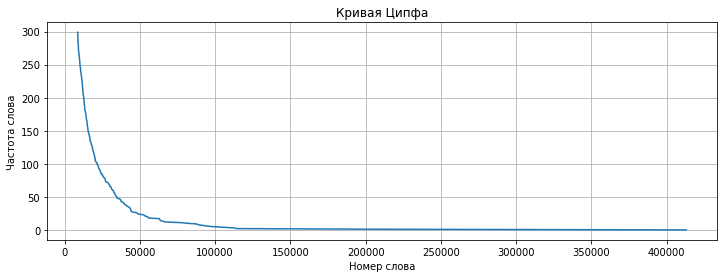

In [32]:
freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(freqs[:300], range(300))
plt.xlabel('Номер слова')
plt.ylabel('Частота слова')
plt.title('Кривая Ципфа')
plt.grid()

plt.show()

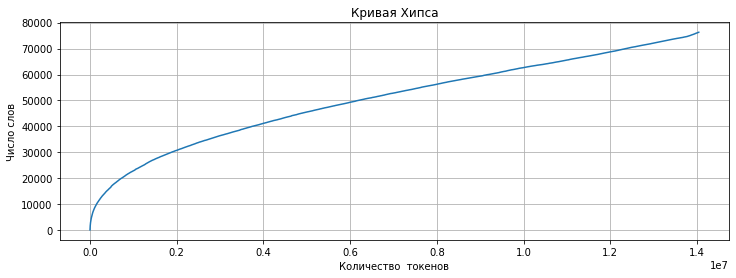

In [33]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(n_tokens,n_types)
plt.xlabel('Количество  токенов')
plt.ylabel('Число слов')
plt.title('Кривая Хипса')
plt.grid()

plt.show()

5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?

In [34]:
from nltk import FreqDist
Freq_Dist = FreqDist(tokens_all)

In [35]:
print('"сотрудник" встрчается: ',Freq_Dist['сотрудник'],'раз')
print('"клиент" встрчается: ',Freq_Dist['клиент'],'раз')

if Freq_Dist['сотрудник'] > Freq_Dist['клиент']:
    print('"Сотрудник" встречается чаще')
else:
    print('"Клиент" встречается чаще')

"сотрудник" встрчается:  88252 раз
"клиент" встрчается:  88018 раз
"Сотрудник" встречается чаще


In [36]:
print('"мошенничество" встрчается: "',Freq_Dist['мошенничество'],'раз')
print('"доверие" встрчается: "',Freq_Dist['доверие'],'раз')

"мошенничество" встрчается: " 1299 раз
"доверие" встрчается: " 1259 раз


#### 6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [37]:
df['rating_grade'].value_counts()

1.0    47387
5.0    14713
2.0    13509
3.0     9261
4.0     3788
Name: rating_grade, dtype: int64

In [38]:
#С виду сбалансированная выборка. Выберем по 7 тысяч примеров

In [39]:
num=7000
df_for_tf_idf = df[(df.rating_grade==1)].sample(n=num).copy()
df_for_tf_idf=df_for_tf_idf.append(df[(df.rating_grade==5)].sample(n=num))

In [40]:
df_for_tf_idf.rating_grade.value_counts()

5.0    7000
1.0    7000
Name: rating_grade, dtype: int64

In [41]:
tokens_by_topic = []

In [42]:
for rating in df_for_tf_idf.rating_grade.unique():
    print(rating)
    #if df['topic'].value_counts()[topic] > 100: 
    tokens=[]
    sample=df_for_tf_idf[df_for_tf_idf['rating_grade']==rating]
    for i in range(len(sample)):
        tokens += sample.lemma.iloc[i].split()
    tokens_by_topic.append(tokens)

1.0
5.0


#### Униграммы

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_topic])
feature_names = tfidf.get_feature_names() 
tfidf_ranking_rank_is_5 = []
tfidf_ranking_rank_is_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_5.append(phrase)
    
text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_1.append(phrase)    

#### На уровне юниграмм , кстати, многое пересекается. Видны некоторые особенности

In [44]:
rankings = pd.DataFrame({'tfidf_ranking_rank_is_5': tfidf_ranking_rank_is_5,'tfidf_ranking_rank_is_1': tfidf_ranking_rank_is_1})
rankings.head(15)

,tfidf_ranking_rank_is_5,tfidf_ranking_rank_is_1
0,банк,банк
1,карта,карта
2,очень,деньга
3,кредит,день
4,день,мой
5,клиент,отделение
6,отделение,который
7,который,кредит
8,деньга,сотрудник
9,сотрудник,счёт


In [45]:
rankings.shape

(70, 2)

#### Попробуем исключить пресекающщиейся леммы из топов

In [46]:
rankings['tfidf_ranking_rank_is_5_without_1']=rankings.tfidf_ranking_rank_is_5[~rankings.tfidf_ranking_rank_is_5.isin(rankings.tfidf_ranking_rank_is_1)]

In [47]:
rankings['tfidf_ranking_rank_is_1_without_5']=rankings.tfidf_ranking_rank_is_1[~rankings.tfidf_ranking_rank_is_1.isin(rankings.tfidf_ranking_rank_is_5)]

In [48]:
#Вот так больше разницу видно
rankings.iloc[:,-2:].dropna()

,tfidf_ranking_rank_is_5_without_1,tfidf_ranking_rank_is_1_without_5
19,обслуживание,ответ
30,интернет,написать
35,минута,ваш
38,весь,говорить
45,хороший,должный
46,первый,почему
49,процент,ситуация
54,несколько,информация


#### Проделаем такое же упражнении для биграмм

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_topic])
feature_names = tfidf.get_feature_names() 
tfidf_ranking_rank_is_5 = []
tfidf_ranking_rank_is_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_5.append(phrase)
    
text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_1.append(phrase) 

In [50]:
# Тоже самое.Проделаем тот же трюк
rankings = pd.DataFrame({'tfidf_ranking_rank_is_5': tfidf_ranking_rank_is_5,'tfidf_ranking_rank_is_1': tfidf_ranking_rank_is_1})
rankings.head(15)

,tfidf_ranking_rank_is_5,tfidf_ranking_rank_is_1
0,интернет банк,сотрудник банк
1,кредитный карта,кредитный карта
2,другой банк,отделение банк
3,сотрудник банк,денежный средство
4,клиент банк,написать заявление
5,следующий день,горячий линия
6,отделение банк,ваш банк
7,являться клиент,рабочий день
8,банк который,колл центр
9,дебетовый карта,альфа банк


In [51]:
rankings['tfidf_ranking_rank_is_5_without_1']=rankings.tfidf_ranking_rank_is_5[~rankings.tfidf_ranking_rank_is_5.isin(rankings.tfidf_ranking_rank_is_1)]

In [52]:
rankings['tfidf_ranking_rank_is_1_without_5']=rankings.tfidf_ranking_rank_is_1[~rankings.tfidf_ranking_rank_is_1.isin(rankings.tfidf_ranking_rank_is_5)]

In [53]:
#Гораздо лучше получилось
rankings.iloc[:,-2:].dropna()

,tfidf_ranking_rank_is_5_without_1,tfidf_ranking_rank_is_1_without_5
12,очень удобно,сей пора
20,хотеть выразить,течение день
21,работа банк,кредитный договор
24,очень быстро,мой деньга
26,мой вопрос,отделение сбербанк
27,пользоваться услуга,мой карта
29,качество обслуживание,получить ответ
32,банк год,мой заявление
33,огромный спасибо,погашение кредит
35,большой спасибо,обратиться отделение


## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [54]:
from gensim.corpora import *
texts = [df.lemma.iloc[i].split() for i in range(len(df))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [55]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [56]:
# 5 тем
lsi_5 = LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)

In [57]:
lsi_5.show_topics(5)

[(0,
  '0.193*"карта" + 0.129*"кредит" + 0.110*"заявление" + 0.109*"деньга" + 0.109*"вклад" + 0.105*"счёт" + 0.104*"банкомат" + 0.098*"отделение" + 0.091*"сумма" + 0.090*"сбербанк"'),
 (1,
  '-0.573*"вклад" + -0.170*"очередь" + 0.165*"кредит" + 0.141*"заявление" + -0.136*"открыть" + 0.131*"платёж" + 0.125*"задолженность" + 0.112*"погашение" + -0.095*"минута" + -0.094*"офис"'),
 (2,
  '0.381*"кредит" + -0.351*"банкомат" + -0.271*"карта" + 0.244*"страховка" + 0.170*"договор" + -0.160*"сбербанк" + 0.140*"страхование" + -0.137*"деньга" + 0.135*"погашение" + -0.128*"операция"'),
 (3,
  '0.365*"вклад" + -0.247*"заявка" + -0.230*"карта" + 0.193*"банкомат" + 0.190*"сумма" + 0.148*"погашение" + 0.146*"платёж" + 0.144*"средство" + 0.139*"руб" + 0.137*"деньга"'),
 (4,
  '-0.455*"банкомат" + -0.312*"страховка" + 0.222*"карта" + 0.189*"задолженность" + -0.182*"страхование" + 0.151*"вклад" + -0.131*"купюра" + -0.120*"заявка" + -0.116*"деньга" + -0.113*"страховой"')]

In [58]:
# 10 тем
lsi_10 = LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)

In [59]:
lsi_10.show_topics(10)

[(0,
  '0.193*"карта" + 0.129*"кредит" + 0.110*"заявление" + 0.109*"деньга" + 0.108*"вклад" + 0.105*"банкомат" + 0.105*"счёт" + 0.098*"отделение" + 0.091*"сумма" + 0.089*"сбербанк"'),
 (1,
  '-0.587*"вклад" + -0.168*"очередь" + 0.147*"кредит" + 0.139*"заявление" + -0.139*"открыть" + 0.125*"платёж" + 0.120*"задолженность" + 0.103*"погашение" + 0.099*"банкомат" + 0.096*"претензия"'),
 (2,
  '0.383*"кредит" + -0.378*"банкомат" + -0.262*"карта" + 0.215*"страховка" + 0.166*"договор" + 0.145*"погашение" + -0.145*"деньга" + -0.144*"сбербанк" + -0.127*"операция" + 0.127*"документ"'),
 (3,
  '0.336*"вклад" + -0.285*"карта" + 0.236*"банкомат" + -0.234*"заявка" + 0.185*"сумма" + 0.149*"деньга" + 0.142*"погашение" + 0.137*"платёж" + 0.135*"средство" + 0.129*"руб"'),
 (4,
  '-0.373*"банкомат" + 0.340*"карта" + 0.234*"вклад" + -0.138*"очередь" + -0.133*"заявка" + 0.130*"задолженность" + -0.130*"кредит" + -0.120*"терминал" + -0.120*"купюра" + 0.117*"комиссия"'),
 (5,
  '0.303*"вклад" + 0.197*"заявка"

Темы
1. Кредитная карта
2. Погаись задолженность по креду
3. Договор погашения
4. Погашенияе средств
5. Рассмотрение комиссии по задолженности
...

In [60]:
# поробуем LDA
from gensim.models.ldamulticore import LdaMulticore

In [61]:
# 5 тем
ldamodel_5 = LdaMulticore(corpus, num_topics=5, id2word = dictionary, passes=20,workers =5)
ldamodel_5.show_topics()

[(0,
  '0.033*"банк" + 0.023*"деньга" + 0.022*"карта" + 0.020*"счёт" + 0.015*"банкомат" + 0.010*"средство" + 0.010*"операция" + 0.009*"день" + 0.009*"сумма" + 0.009*"мой"'),
 (1,
  '0.037*"банк" + 0.027*"кредит" + 0.012*"сумма" + 0.011*"договор" + 0.010*"день" + 0.010*"мой" + 0.010*"сотрудник" + 0.009*"платёж" + 0.008*"который" + 0.008*"кредитный"'),
 (2,
  '0.050*"карта" + 0.022*"банк" + 0.012*"день" + 0.011*"звонить" + 0.010*"сказать" + 0.009*"позвонить" + 0.008*"отделение" + 0.008*"заявление" + 0.008*"телефон" + 0.008*"мой"'),
 (3,
  '0.037*"банк" + 0.013*"клиент" + 0.011*"очень" + 0.007*"который" + 0.006*"сотрудник" + 0.006*"работа" + 0.006*"время" + 0.006*"обслуживание" + 0.006*"свой" + 0.006*"год"'),
 (4,
  '0.019*"отделение" + 0.018*"деньга" + 0.015*"банк" + 0.015*"вклад" + 0.010*"очередь" + 0.009*"работать" + 0.009*"сказать" + 0.009*"офис" + 0.007*"минута" + 0.007*"касса"')]

In [62]:
# 10 тем
ldamodel_20 = LdaMulticore(corpus, num_topics=10, id2word = dictionary, passes=20,workers =5)
ldamodel_20.show_topics()

[(0,
  '0.056*"деньга" + 0.052*"банкомат" + 0.020*"банк" + 0.017*"день" + 0.016*"карта" + 0.010*"снять" + 0.009*"мой" + 0.009*"терминал" + 0.009*"заявление" + 0.009*"сумма"'),
 (1,
  '0.048*"банк" + 0.036*"карта" + 0.012*"год" + 0.010*"обслуживание" + 0.010*"комиссия" + 0.009*"счёт" + 0.009*"очень" + 0.008*"кредитный" + 0.008*"процент" + 0.008*"интернет"'),
 (2,
  '0.022*"банк" + 0.015*"перевод" + 0.015*"деньга" + 0.014*"счёт" + 0.010*"интернет" + 0.010*"операция" + 0.010*"проблема" + 0.009*"система" + 0.009*"платёж" + 0.008*"день"'),
 (3,
  '0.037*"вклад" + 0.032*"банк" + 0.015*"деньга" + 0.011*"отделение" + 0.011*"офис" + 0.011*"открыть" + 0.011*"счёт" + 0.009*"договор" + 0.009*"сказать" + 0.007*"день"'),
 (4,
  '0.032*"кредит" + 0.029*"банк" + 0.020*"документ" + 0.015*"заявка" + 0.014*"день" + 0.009*"сказать" + 0.008*"кредитный" + 0.008*"договор" + 0.007*"страховка" + 0.007*"менеджер"'),
 (5,
  '0.028*"счёт" + 0.027*"заявление" + 0.022*"сбербанк" + 0.021*"г" + 0.020*"сумма" + 0.017*

#### 2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Из всех банков в  выборке в тематики попали только Сбер и Альфа. Их больше всего в датасете

In [63]:
df.bank_name.value_counts(normalize=1).head()

Сбербанк России     0.168558
Альфа-Банк          0.060660
ВТБ 24              0.053870
Русский Стандарт    0.049268
Хоум Кредит Банк    0.045433
Name: bank_name, dtype: float64

### LSI:

####  Сбер
    
   - '0.309*"вклад" + 0.193*"заявка" + 0.190*"заявление" + 0.169*"сбербанк" + 0.160*"рассмотрение" + -0.143*"комиссия" + -0.132*"платеж" + -0.127*"карта" + 0.125*"срок" + 0.124*"обращение" - вот она бюрократия зеленого банка

   - '0.356*"страховка" + 0.302*"банкомат" + 0.233*"карта" + -0.222*"платеж" + 0.188*"страхование" + 0.171*"заявка" + -0.147*"номер" + -0.139*"перевод" + 0.125*"вклад" + -0.123*"сбербанк"' - видимо есть какие-то проблемы со страховкой
 


#### Альфа
 - 0.442*"альфа" + -0.211*"услуга" + -0.208*"претензия" + -0.198*"смс" + -0.180*"подключать" + 0.179*"платеж" + -0.171*"закрывать" + -0.154*"справка" + -0.146*"закрытие" + 0.142*"кошелек"' -какая-то операционная тематика, сложно сказать что-то
 - 0.392*"горячий" + -0.389*"линия" + -0.341*"справка" + 0.184*"карточка" + -0.173*"терминал" + -0.170*"комиссия" + 0.167*"платеж" + -0.166*"руб" + 0.141*"альфа" + -0.132*"связной" - вот это вот любопытно,  очевидно речь идет о какой-то услуге которую свзяной оказывает(термина, связной, коммисия) я б тут покапался
 - 0.344*"сбербанк" + 0.199*"заявление" + 0.198*"подключать" + -0.194*"альфа" + 0.189*"услуга" + 0.188*"смс" + 0.181*"досрочный" + 0.179*"справка" + 0.173*"погашение" + -0.169*"претензия"' - здесь интресно что и сбер и альфа фигурирует видимо у обоих были проблемы с интернет банком

### LDA:

####  Сбер


 - '0.051*"деньги" + 0.038*"банкомат" + 0.018*"сбербанк" + 0.017*"день" + 0.014*"банк" + 0.013*"заявление" + 0.012*"счет" + 0.011*"карта" + 0.010*"отделение" + 0.009*"операция"' - тут также сложно скзазать, видимо речь идет о проблемах с картами
 - '0.103*"сбербанк" + 0.033*"отделение" + 0.025*"деньги" + 0.023*"г" + 0.020*"платеж" + 0.014*"счет" + 0.012*"оплачивать" + 0.011*"сбер" + 0.010*"терминал" + 0.010*"оплата"'- видимо о какахто платежах через терминалы итдет речь

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

### 1) Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение).
Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.1) 

#### Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

In [64]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,text_tokinized,text_tokinized_without_stop_worlds,lemma,NOUN
14,г. Москва,False,В Шоке,0,лицензия № 2673,yura1189,Тинькофф Банк,2015-06-05 13:52:40,"Также как и многие давний клиент банка, был до...",2.0,также как и многие давний клиент банка был дов...,многие давний клиент банка доволен высшей степ...,многие давний клиент банк довольный высокий ст...,клиент банк степень друг большинство сотрудник...
19,г. Москва,False,Некомпетентность сотрудников банка,2,лицензия № 1481,agelun,Сбербанк России,2015-06-05 15:00:54,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0,открыт вклад и счет в плюс к этому есть зарпла...,открыт вклад счет плюс этому зарплатная карта ...,открыть вклад счёт плюс этот зарплатный карта ...,вклад счёт карта рубль отделение цель операцио...
33,г. Ростов-на-Дону,False,Навязывание страховки,1,лицензия № 1481,Joker888,Сбербанк России,2015-06-05 21:35:40,Доброго времени! Вчера мне поступило смс-уведо...,1.0,доброго времени вчера мне поступило смс уведом...,доброго времени вчера поступило смс уведомлени...,добрый время вчера поступить смс уведомление б...,время смс уведомление банк предложение кредит ...
76,г. Санкт-Петербург,False,Нарушение договора банковского вклада,0,лицензия № 3006,qwarta45,АктивКапитал Банк,2015-06-06 23:42:39,"05.06.2015г. около 15 часов, пришел в указанны...",1.0,г около часов пришел в указанный офис с намере...,г около часов пришел указанный офис намерением...,г около час прийти указанный офис намерение по...,г час офис намерение вклад небо менежер го июн...
85,г. Москва,False,"Невозможно оплатить отчисления на капремонт ""Т...",4,лицензия № 1481,721,Сбербанк России,2015-06-04 13:27:04,Для оплаты коммунальных платежей пользуюсь пла...,1.0,для оплаты коммунальных платежей пользуюсь пла...,оплаты коммунальных платежей пользуюсь пластик...,оплата коммунальный платёж пользоваться пласти...,оплата платёж карта сайт банк пора отчисление ...


In [65]:
num=4000
df_for_tf_idf = df[(df.rating_grade==1)].sample(n=num).copy()
df_for_tf_idf=df_for_tf_idf.append(df[(df.rating_grade==5)].sample(n=num))

df_for_tf_idf.rating_grade.value_counts()

5.0    4000
1.0    4000
Name: rating_grade, dtype: int64

In [66]:
df_for_tf_idf.rating_grade.value_counts()

5.0    4000
1.0    4000
Name: rating_grade, dtype: int64

In [67]:
X=df_for_tf_idf.lemma.values
y=df_for_tf_idf.rating_grade.values

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42,stratify=y)

In [69]:
import collections, numpy
collections.Counter(y_test)

Counter({5.0: 1200, 1.0: 1200})

#### 2) Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baselin. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных  𝑛 -грам.

In [70]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
clf_countvectorized = Pipeline([
    ('vect', CountVectorizer()),
   ('clf', LogisticRegression()),])

In [71]:
params_cntv={
    'vect__analyzer':  ['word','char'],
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (2, 2), (3, 3)),
     "clf__C": np.logspace(-3,3,7),
     "clf__penalty":["l1","l2"]
}
scores=[ 'accuracy','f1']
grid_cntv = GridSearchCV(clf_countvectorized, param_grid=params_cntv, cv=3,
                         scoring=scores,refit=scores[0],
                         n_jobs=-1, verbose=1)
grid_cntv.fit(X_train, y_train)
print(grid_cntv.best_estimator_)
print("Best score: %0.3f" % grid_cntv.best_score_)

Fitting 3 folds for each of 252 candidates, totalling 756 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 756 out of 756 | elapsed:  5.3min finished


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.5,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                          

Precision:   0.94
Recall:   0.94
F1-measure:   0.93
Accuracy:   0.94
              precision    recall  f1-score   support

         1.0       0.94      0.93      0.93      1200
         5.0       0.93      0.94      0.94      1200

    accuracy                           0.94      2400
   macro avg       0.94      0.94      0.93      2400
weighted avg       0.94      0.94      0.93      2400



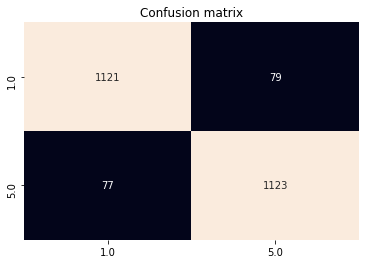

In [72]:
from sklearn.metrics import *
import seaborn as sns
predictions=grid_cntv.best_estimator_.predict(X_test)
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))


labels = grid_cntv.best_estimator_.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [73]:
import warnings
warnings.filterwarnings('ignore')

In [74]:

Count_vectorized_model=pd.DataFrame.from_dict(grid_cntv.cv_results_)

In [75]:
print(grid_cntv.best_estimator_)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.5,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                          

#### Грид на выбрал как лучший униграммы по словам

In [76]:
Count_vectorized_model[['param_clf__C','param_clf__penalty','param_vect__analyzer','param_vect__max_df','param_vect__ngram_range','mean_test_accuracy','mean_test_f1']].sort_values('mean_test_accuracy', ascending=False).head(15)

,param_clf__C,param_clf__penalty,param_vect__analyzer,param_vect__max_df,param_vect__ngram_range,mean_test_accuracy,mean_test_f1
90,0.1,l2,word,0.50,"(1, 1)",0.932144,0.932185
96,0.1,l2,word,1.00,"(1, 1)",0.931609,0.931723
93,0.1,l2,word,0.75,"(1, 1)",0.931430,0.931472
129,1.0,l2,word,0.75,"(1, 1)",0.930537,0.930626
132,1.0,l2,word,1.00,"(1, 1)",0.930180,0.930213
126,1.0,l2,word,0.50,"(1, 1)",0.929823,0.929909
162,10.0,l2,word,0.50,"(1, 1)",0.928929,0.928988
165,10.0,l2,word,0.75,"(1, 1)",0.928394,0.928442
168,10.0,l2,word,1.00,"(1, 1)",0.928037,0.928002
201,100.0,l2,word,0.75,"(1, 1)",0.927143,0.927100


### Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
      1-ый вариант:  𝑡𝑓−𝑖𝑑𝑓  преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
      2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).

#### 1-ый вариант:  𝑡𝑓−𝑖𝑑𝑓  преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),

Попробуем только 𝑡𝑓−𝑖𝑑𝑓  

In [77]:
clf_tf_idf = Pipeline([        
   ('vect', CountVectorizer()), 
       ('tfidf', TfidfTransformer()),   
   ('clf', LogisticRegression()),
])

In [78]:
params_tf_idf={
    
    'vect__analyzer':  ['word','char'],
    
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
     "clf__C": np.logspace(-3,3,7),
     "clf__penalty":["l1","l2"] 
}
scores=[ 'accuracy','f1']
grid_tf_idf = GridSearchCV(clf_tf_idf, param_grid=params_tf_idf, cv=3,
                         scoring=scores,refit=scores[0],
                         n_jobs=-1, verbose=1)
grid_tf_idf.fit(X_train, y_train)
print(grid_tf_idf.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf.best_score_)

Fitting 3 folds for each of 1008 candidates, totalling 3024 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1238 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1788 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 2438 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 3024 out of 3024 | elapsed: 20.7min finished


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.75,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=10.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,


In [79]:
grid_tf_idf.estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__C', 'clf__class_weight', 'clf__dual', 'clf__fit_intercept', 'clf__intercept_scaling', 'clf__l1_ratio', 'clf__max_iter', 'clf__multi_class', 'clf__n_jobs', 'clf__penalty', 'clf__random_state', 'clf__solver', 'clf__tol', 'clf__verbose', 'clf__warm_start'])

Немного улучшились реузльтаты

Precision:   0.95
Recall:   0.95
F1-measure:   0.95
Accuracy:   0.95
              precision    recall  f1-score   support

         1.0       0.94      0.95      0.95      1200
         5.0       0.95      0.94      0.95      1200

    accuracy                           0.95      2400
   macro avg       0.95      0.95      0.95      2400
weighted avg       0.95      0.95      0.95      2400



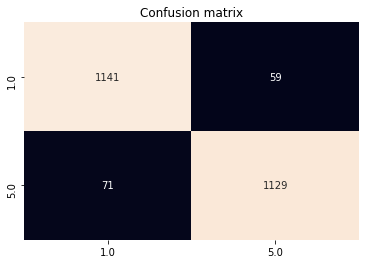

In [80]:
predictions=grid_tf_idf.best_estimator_.predict(X_test)
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))

labels = grid_tf_idf.best_estimator_.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Попробуем добавить сигнулярное разложение

In [84]:
 clf_tf_idf_TruncatedSVD = Pipeline([    
   ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),   
    ('tsvd', TruncatedSVD()),   
   ('clf', LogisticRegression()),
])

In [85]:
params_tf_idf_TruncatedSVD={
    
    'vect__analyzer':  ['word'],
    #'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'tsvd__n_components' : [5,10,25,50,100],
     "clf__C": np.logspace(-3,3,7),
     "clf__penalty":["l1","l2"]
}

scores=[ 'accuracy','f1']
grid_tf_idf_TruncatedSVD = GridSearchCV(clf_tf_idf_TruncatedSVD, param_grid=params_tf_idf_TruncatedSVD, cv=3,
                         scoring=scores,refit=scores[0],
                         n_jobs=-1, verbose=1)
grid_tf_idf_TruncatedSVD.fit(X_train, y_train)
print(grid_tf_idf_TruncatedSVD.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf_TruncatedSVD.best_score_)

Fitting 3 folds for each of 210 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed: 19.8min finished


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 TruncatedSVD(algorithm='randomized', n_components=100,
                              n_iter=5, random_state=None, tol=0.0)),
                ('clf',
                 LogisticRegression(C=100.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                 

Precision:   0.93
Recall:   0.93
F1-measure:   0.93
Accuracy:   0.93
              precision    recall  f1-score   support

         1.0       0.92      0.93      0.93      1200
         5.0       0.93      0.92      0.93      1200

    accuracy                           0.93      2400
   macro avg       0.93      0.93      0.93      2400
weighted avg       0.93      0.93      0.93      2400



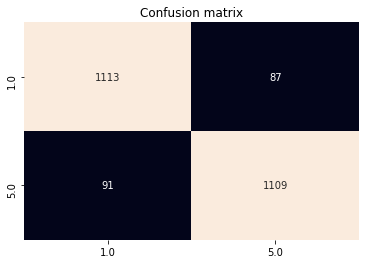

In [86]:
predictions=grid_tf_idf_TruncatedSVD.best_estimator_.predict(X_test)
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))

labels = grid_tf_idf_TruncatedSVD.best_estimator_.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

#### 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).

In [87]:
clf_tf_idf_LDA = Pipeline([
   ('vect', CountVectorizer()),   
    ('lda', LatentDirichletAllocation()),   
   ('clf', LogisticRegression()),
])

In [88]:
params_tf_idf_LDA={    
    'vect__analyzer':  ['word'],
    'vect__max_df': [0.75],
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'lda__n_components' : [25,50,100],
     "clf__C": np.logspace(-3,3,7),
     "clf__penalty":["l1","l2"]
}

scores=[ 'accuracy','f1']
grid_tf_idf_LDA = GridSearchCV(clf_tf_idf_LDA, param_grid=params_tf_idf_LDA, cv=3,
                         scoring=scores,refit=scores[0],
                         n_jobs=-1, verbose=1)
grid_tf_idf_LDA.fit(X_train, y_train)
print(grid_tf_idf_LDA.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf_LDA.best_score_)

Fitting 3 folds for each of 126 candidates, totalling 378 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 378 out of 378 | elapsed: 48.7min finished


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.75,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=No...
                                           perp_tol=0.1, random_state=None,
                                           topic_word_prior=None,
                                           total_samples=1000000.0,
                                           verbose=0)),
                ('clf',
                 LogisticRegression(C=1000.0, 

LDA сильно ухудшил результаты

Precision:   0.89
Recall:   0.89
F1-measure:   0.89
Accuracy:   0.89
              precision    recall  f1-score   support

         1.0       0.89      0.90      0.89      1200
         5.0       0.90      0.89      0.89      1200

    accuracy                           0.89      2400
   macro avg       0.89      0.89      0.89      2400
weighted avg       0.89      0.89      0.89      2400



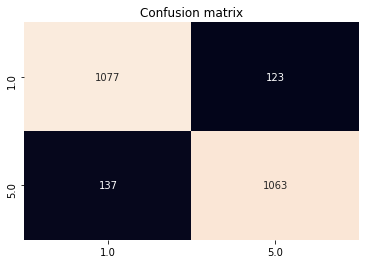

In [89]:
predictions=grid_tf_idf_LDA.best_estimator_.predict(X_test)
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))

labels = grid_tf_idf_LDA.best_estimator_.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Итого:

In [90]:
models=['grid_cntv', 'grid_tf_idf' ,'grid_tf_idf_TruncatedSVD', 'grid_tf_idf_LDA']
for model in models:

    print('model: ',model[5:])
    predictions=eval(model).best_estimator_.predict(X_test)
    print("F1-measure: {0:6.3f}".format(f1_score(y_test, predictions, average='macro')),';',"Accuracy: {0:6.3f}".format(accuracy_score(y_test, predictions)))

model:  cntv
F1-measure:  0.935 ; Accuracy:  0.935
model:  tf_idf
F1-measure:  0.946 ; Accuracy:  0.946
model:  tf_idf_TruncatedSVD
F1-measure:  0.926 ; Accuracy:  0.926
model:  tf_idf_LDA
F1-measure:  0.892 ; Accuracy:  0.892


#### TF-IDF показывает лучший результат